<a href="https://colab.research.google.com/github/Vamsikrishna1804/INFO-5505-Advanced-Machine-Learning-for-Data-Scientists-/blob/main/Muktinutalapati_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Getting data from url
import base64
import requests
re = requests.get ('http://www.cse.chalmers.se/~richajo/dit862/data/all_sentiment_shuffled.txt')
re.encoding = 'utf-8'
data = re.text

In [ ]:
# Printing data type and observing the original format of the data
print("data's type:  ", type(data))
print(data[:200])

data's type:   <class 'str'>
music neg 241.txt i bought this album because i loved the title song . it 's such a great song , how bad can the rest of the album be , right ? well , the rest of the songs are just filler and are n't


From the above code block result, it is evident that the given data format is of string type.

In [ ]:
# Reformatting the data

# Creating empty lists of 4 data attributes:  reviews, topics, labels, and documment ids
reviews, topics, labels, doc_id = [],[],[],[]

# Looping over lines to separate them into separated attributes
for line in data.splitlines():
  reviews.append(' '.join(token for token in line.split()[3:]))
  topics.append(line.split()[0])
  labels.append(line.split()[1])
  doc_id.append(line.split()[2])

# Storing the separated data into dataframe
df = pd.DataFrame(zip(doc_id, reviews, topics, labels), columns = ['doc_id', 'review', 'topic', 'label'])
print("data's shape: ", df.shape)
df.head()

data's shape:  (11914, 4)


,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,neg
1,544.txt,i was misled and thought i was buying the enti...,music,neg
2,729.txt,"i have introduced many of my ell , high school...",books,neg
3,278.txt,anything you purchase in the left behind serie...,books,pos
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,pos


In the above code block, all the text data from the given URL is filtered into a line using for loop and appended it to their respective empty created list variables. After appending values to the list variables, dataframe with values has been created and shape of the dataframe is printed.

Checking for any null values in a dataframe

In [ ]:
df.isnull().sum()

doc_id    0
review    0
topic     0
label     0
dtype: int64

From the above code block result, it is evident that there are no null values in any of the fields.

**Exploring the dependent variable**

data distribution in the dependent variable:
 pos    6000
neg    5914
Name: label, dtype: int64


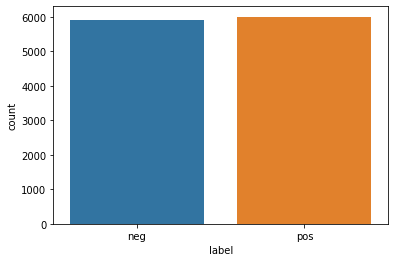

In [ ]:
print('data distribution in the dependent variable:\n', df['label'].value_counts())
sns.countplot(data = df, x = 'label')
plt.show()

Count plot has been plotted on the dependent variable to know the distribution. From the above graph, it is evident that there are 6000 positive text rows and 5914 negative text rows in a dataframe.

Fortunately, the data equally distributes in two classes of the dependent variable.

Here, we have to encode labeled classes into numerics so that the machine can understand.

In [ ]:
# Encoding the target labels into the numeric type
df['label'] = np.where(df['label']=='pos', 1, 0)
df.head()

,doc_id,review,topic,label
0,241.txt,i bought this album because i loved the title ...,music,0
1,544.txt,i was misled and thought i was buying the enti...,music,0
2,729.txt,"i have introduced many of my ell , high school...",books,0
3,278.txt,anything you purchase in the left behind serie...,books,1
4,840.txt,"i loved these movies , and i cant wiat for the...",dvd,1


**Cleaning Data**

When doing text classification, data cleaning is an essential part, deciding the model's performance. Some stopwords such as 'the','a', etc. occur most frequently, but contain no useful information. We expect to remove these words from the corpus to reduce feature dimensions that may improve perfomance of models.

**Removing stop words, numeric, and non-letter tokens**

In [ ]:
# Downloading a stopword list in English
!pip install stop-words
from stop_words import get_stop_words
stop_words = get_stop_words('en')

# Removing stopwords, and numerics 
df['review'] = df['review'].apply( lambda x: ' '.join([x for x in str(x).split() if not x.isdigit() and not x.isspace() ]) )
df['review'] = df['review'].apply( lambda x: ' '.join([x for x in str(x).split() if x not in stop_words]) )
df['review'].head()

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=f8e241130a1b01fb591b1423eae44e7e4d93601fc701372bac942956dac218b0
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


0    bought album loved title song . 's great song ...
1    misled thought buying entire cd contains one song
2    introduced many ell , high school students loi...
3    anything purchase left behind series excellent...
4    loved movies , cant wiat third one ! funny , s...
Name: review, dtype: object

In [ ]:
# Removing punctuations and non-letter tokens
df['review']=df['review'].str.replace('[^\w\s]','')
df['review'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0    bought album loved title song  s great song  b...
1    misled thought buying entire cd contains one song
2    introduced many ell  high school students lois...
3    anything purchase left behind series excellent...
4    loved movies  cant wiat third one  funny  suit...
Name: review, dtype: object

**Developping a Naive Bayes model**

We are going to implement the Naive Bayes algorithm for multinomially distributed data. The Naive Bayes make assumptions that all attributes or hereby words are independent of each other, and the word positions are unimportant.

**Splitting the data for training and testing**

We will split our data into two parts: training (80%) and test set (20%). We will split our data for training and testing before transforming it into a matrix of token counts. The reason for doing that is that we want to observe the original data (the data before transformation), together with our predicted sentiments for analyzing misclassification. If we transformed before spliting data for training and testing, we will not be able to do so.

We use the training set for training and validating the model by using k-fold cross validation with 5 folds. For each iteration, 4 folds will be used for training and 1 set for validating.

We only use the test set for our final evaluation only; meaning that it will not participate in any training steps.By doing so, we can ensure having the most reliable evaluation result before deploying the model.

In [ ]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (9531,) (9531,)
Shapes of X_test, y_test:  (2383,) (2383,)


**Document representation and data tranformation**

The computer is unable to read and understand text data, and features are not available in the dataset like the numeric dataset. We have to represent the text or documents into vector representation. There are a variety of methods to represent the documents such as term frequency, tf-idf, etc. Here we will count term frequency for presentating the reviews (called documents). We will tokenize each review (shown as an instance) that has been cleaned, then count the token frequency. As a result, we will have a a matrix of token counts representing the whole corpus. Features are basically single words or tokens.

In [ ]:
# Converting a collection of text documents to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
# Creating a vectorizer model that convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(lowercase = False)

In [ ]:
# For training set:
# Fitting the vectorizer model into the training set and then returning document-term matrix of that set
X_train_tf = vectorizer.fit_transform(X_train)

# Converting  sparse matrix to a dense matrix
X_train_tf_dm = X_train_tf.toarray()
print ('Shapes of transformed X_train, y_train: ', X_train_tf_dm.shape, y_train.shape)


Shapes of transformed X_train, y_train:  (9531, 47444) (9531,)


In [ ]:
print('The number of features: ', len(vectorizer.get_feature_names()))

The number of features:  47444


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Transforming the test set and returning document-term matrix of that set
X_test_tf = vectorizer.transform(X_test)

# Converting  sparse matrix to a dense matrix
X_test_tf_dm = X_test_tf.toarray()
print ('Shapes of transformed X_train, y_train: ', X_train_tf_dm.shape, y_train.shape)


Shapes of transformed X_train, y_train:  (9531, 47444) (9531,)


We have 47,444 features. The number of features we have is actually the size of our vocabulary size because we did not limit the maximum number of features.

In [ ]:
# Observing the documment term-matrix of the trainingset
pd.DataFrame(X_train_tf_dm, columns = vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,00000,000feet,000mb,000page,000steps,01,010,02071982,...,zzzzz,àvis,ça,énnui,ï½50,ï½bersoldier,ï½bersoldiers,ï½kerlund,ï½vis,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Training Model

In [ ]:
# Creating a naive bayes models for text classification
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# Fitting the model into the training set for learning
mnb.fit(X_train_tf_dm, y_train)

MultinomialNB()

In [ ]:
# Training and validating the model using k-fold cross validation
from sklearn.model_selection import cross_validate
cv = cross_validate (mnb, X_train_tf_dm, y_train, cv = 5)
print("accuracy score of 5-fold cross validation:\n", cv['test_score'])
print("cross validation accuracy mean score: \n", cv['test_score'].mean())


accuracy score of 5-fold cross validation:
 [0.81331935 0.80167891 0.77964323 0.795383   0.795383  ]
cross validation accuracy mean score: 
 0.7970814984942536


By using the k-fold cross validation, we got a generalized estimated accuracy score of the model of around 80% This score is not high, but acceptable for the text classification.

Making Prediction 

In [ ]:
# Applying the learned model to make prediction on the test set
y_pred = mnb.predict(X_test_tf_dm)

In [ ]:
# Analyzing misclassified reviews
pd.set_option('display.max_colwidth', None)
test_df = pd.DataFrame(zip(X_test, y_test, y_pred), columns = ['X_test','y_test', 'y_pred'])
test_df[test_df['y_test'] != test_df['y_pred'] ][:5]

,X_test,y_test,y_pred
5,buy cable amazon wo nt sorry looked internet sometimes hard find good company online buy manufacture sold cables friend told amazon typed cable number amazon stock decided order hope best well sure enough cable arrived time just like amazon said know great working usb cable digital camera order three since friends family always ask borrow mine fact need replacement money buy five fact family friends always misplacing cables losing order cable amazon nice know lose cables can buy ever since bought cables making sure know put em happy buy worries,1,0
11,wipes great three children used pampers huggies housebrand wipes huggies thick seems need get job done housebrand nt smell good tend bit rough pampers thin soft moist enough get job donebecause thin can maneuvered around important places folded refolded 100 useage unlike huggies folded become thick maneuver definitely dry reviewers said want something moister go get paper towel wet water,1,0
17,hesitant spend much money shaver glad one gives really good shave one month used hand razor since another review says cleaning process bit loud since turn leave just close bathroom door noise problem,1,0
18,loved first one think logic plot first one follows knew changed world sequel see actors good since lead characters suppose let s say less intelligent nice think movie 1st one classics like grim reaper atitude movie fact comic relief okay movie comic relief even fun watch laugh worth watch,1,0
31,stuff rap dreams made just like movie cd packed moment moment perpetual rollercoaster type thrills leaves listener sheer state funk frenzy talent assmbled tops just seems keep coming get sit buckle shut fk s get rowdy,1,0


We will evaluate the model performance on the test set. We aim to evaluate the model performance with three popular evaluation methods: Accuracy Score, confusion matrix, and ROC Curve.



In [ ]:
# Evaluating the model on the test set
print('Accuracy of the selected model in the test set: {:.4f}'.format(mnb.score(X_test_tf_dm, y_test)))

Accuracy of the selected model in the test set: 0.8225


Text(33.0, 0.5, 'actual values')

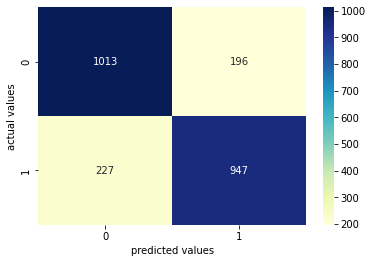

In [ ]:
# Evaluating with the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Visualizing the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = '.0f',cmap='YlGnBu')
plt.xlabel ('predicted values')
plt.ylabel ('actual values')

Looking at the confusion matrix, we can see the model correctly predicted 1013 reviews as True Positives, and 947 True Negatives. However, the model incorrectly predict 227 Negative reviews as positive. Likewise, 196 positive reviews were incorrectly predicted as negatives.

**With the ROC Curve**

The Receiver Operating Characteristic (ROC) Curve was created by plotting the true positive rate (TPR) against the false positive rate (FPR). The ROC Curve is a probability curve, telling us how much the model is able to distinguish between classes, shown by the area under the curve (AUC). Higher the AUC is, the better the model performs. The AUC is expected to greater than 0.5, or over left-top part compared to the baseline.

The ROC AUC:  0.8845287262059257


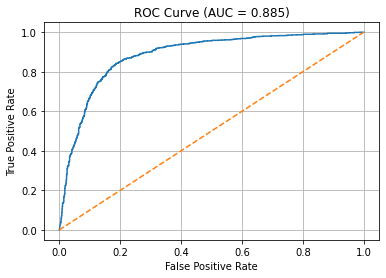

In [ ]:
# Evaluating with the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
# Taking only the probability of the positive review (class 1) on the test set
y_pred_prob_c1  = mnb.predict_proba (X_test_tf_dm)[:,1]

# Getting True Positive Rate (tpr) and False Positive Rate (fpr)
fpr, tpr, threshold = roc_curve (y_test, y_pred_prob_c1, pos_label = 1)

# Computing the area under the ROC Curve (roc_auc)
roc_auc_score = roc_auc_score (y_test, y_pred_prob_c1)
print('The ROC AUC: ', roc_auc_score) 

# Visualizing the ROC Curve
plt.plot (fpr, tpr)
plt.plot([0,1], '--')
plt.xlabel ('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title ("ROC Curve (AUC = {:.3f})".format(roc_auc_score))
plt.grid()
plt.show()

The AUC above indicates that our model can distinguish the two classes (positive (1) and negative (0)) pretty well.